In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy 
from scipy.linalg import norm
from scipy.special import iv
from scipy.stats import beta

In [2]:
from matplotlib import rc

# Configure Matplotlib to use LaTeX
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})

# Empirical Bounds

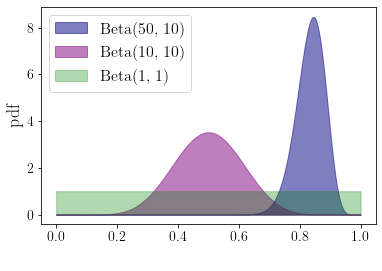

In [19]:
x = np.linspace(0, 1, 1000)

r1 = beta.pdf(x, 50, 10)
r2 = beta.pdf(x, 10, 10)
r3 = beta.pdf(x, 1, 1)

plt.fill_between(x, r1, color='navy', alpha=0.5, label="Beta(50, 10)")
plt.fill_between(x, r2, color='purple', alpha=0.5, label="Beta(10, 10)")
plt.fill_between(x, r3, color='green', alpha=0.3, label="Beta(1, 1)")
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('x', color='white')
plt.ylabel('pdf')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('beta_dists.png', dpi=300, bbox_inches='tight')

In [23]:

def lambd(i, alpha, sigma2): 
    
    opt_c = 2 + 8/(3*np.log(1/alpha))
    top = opt_c * np.log(1/alpha)
    bottom = i * np.log(i+1) * sigma2
    return min(np.sqrt(top / bottom), 0.5)

def psiE(x):
    assert 0 < x < 1
    return -x - np.log(1 - x)

def A(d, kappa): 
    return iv(d/2, kappa) / iv(d/2-1, kappa)


def emp_bernstein(alpha, B, d, iters, gen_vec): 

    adk = A(d, np.sqrt(d))
    
    emp_mean_numerator = 1/2
    running_numerator = 4*B*np.sqrt(d)*adk + 2*B*np.sqrt(d)*np.log(1/alpha)
    running_denominator = 0

    sigma_hat_top = 1/4

    width = []
    
    for i in range(1,int(iters)): 

        # Compute lambda 
        lmd = lambd(i, alpha, sigma_hat_top/i)

        # Get observations 
        newX = gen_vec(d)

        # Update width 
        running_numerator += psiE(lmd) *(1/ (2*B)) * (norm(newX - emp_mean_numerator / i))**2 
        running_denominator += adk*lmd
        
        width.append(min(running_numerator/running_denominator, 1))
        
        # Update sigma and empirical mean 
        emp_mean_numerator += newX 
        sigma_hat_top += norm(newX - (emp_mean_numerator / (i+1)))**2
        
    return width 


def subG_boundary(d, alpha, sigma, iters): 
    
    num = np.sqrt(d)*2 + np.sqrt(d) * np.log(1/alpha) 
    denom = 0
    
    width = []
    for i in range(1, int(iters)): 
        
        lmb = np.sqrt(np.log(1/alpha) / (i * np.log(i+1) * sigma**2))
        num += np.sqrt(d) * (sigma**2) * (lmb**2) / 2
        denom += (2/3) * lmb 
        width.append(min(num /denom, 1))
        
    return width 

    
def BernBoundary(alpha, sigma2, d, iters): 
    
    widths = []
    for i in range(1, int(iters)): 
        
        alphat = alpha / (i**2 * 2)
        width = np.sqrt(8*sigma2*(np.log(1/alphat) + 1/4) /i)
        widths.append(min(width, 1))

    return widths

def HoeffBoundary(alpha, d, iters): 
    
    widths = []
    for i in range(1, int(iters)): 
        
        alphat = alpha / (i**2 * 2)
        width = np.sqrt(2*d**2*(np.log(1/alphat)) /i)
        widths.append(min(width, 1))

    return widths
    
    

In [37]:
p =  0.1

def gen_unif_vec(d): 
    return beta.rvs(1,1, size=d)

def gen_beta1_vec(d): 
    # with probability 1/2 sample from Binomial(0.8)
    # with probability 1/2 sample from Beta(10, 10)
    if np.random.rand() < p:
        return np.random.binomial(1, 0.8, size=d) 
    else:
        return beta.rvs(10, 10, size=d) 

def gen_beta2_vec(d): 
    if np.random.rand() < p: 
        return np.random.binomial(1, 0.8, size=d)
    return beta.rvs(50, 10, size=d)
    # if np.random.rand() < 0.5:
    #     return np.random.binomial(1, 0.9, size=d) 
    # else:
    #     return beta.rvs(50, 10, size=d)

def var1(d): 
    return d * 1/12
    var_1d = p**2 * 0.8*0.2 + (1-p)**2 * 10**2 / ((20**2 * 21))
    return d*var_1d
    # return d * 10**2 / ((20**2 * 21))

def var2(d): 
    var_1d = p**2 * 0.8*0.2 + (1-p)**2 * 50**2 / ((60**2 * 61))
    return d * var_1d

In [38]:
alpha = 0.05 
d = 5 
B = d/2
iters = 10e3

trials = 100

# width_hoeff = HoeffBoundary(alpha, d, iters)
width_bern1 = BernBoundary(alpha, var1(d), d, iters)
width_bern2 = BernBoundary(alpha, var2(d), d, iters)
beta1 = []
beta2 = []
unif = []
for _ in range(trials): 

    beta1.append(emp_bernstein(alpha, B, d, iters, gen_beta1_vec)) 
    beta2.append(emp_bernstein(alpha, B, d, iters, gen_beta2_vec)) 
    unif.append(emp_bernstein(alpha, B, d, iters, gen_unif_vec))



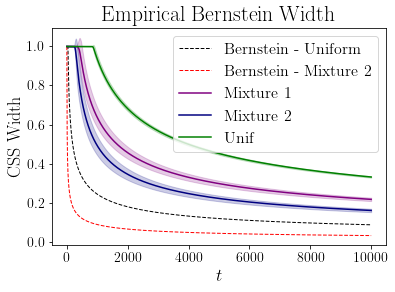

In [41]:
plt.plot(width_bern1, c='k', lw=1, ls='--', label='Bernstein - Uniform')
plt.plot(width_bern2, c='r', lw=1, ls='--', label='Bernstein - Mixture 2')
# plt.plot(width_hoeff, c='b', lw=1, ls='--', label='Hoeffding')

# Mean of beta1
beta1_mean = np.mean(beta1, axis=0)
beta1_std = np.std(beta1, axis=0)
plt.plot(beta1_mean, label="Mixture 1", color='purple')
plt.fill_between(range(len(beta1_mean)), beta1_mean - 2*beta1_std, beta1_mean + 2*beta1_std, color='purple', alpha=0.2)

# Mean of beta2
beta2_mean = np.mean(beta2, axis=0)
beta2_std = np.std(beta2, axis=0)
plt.plot(beta2_mean, label="Mixture 2", color='navy')
plt.fill_between(range(len(beta2_mean)), beta2_mean - 2*beta2_std, beta2_mean + 2*beta2_std, color='navy', alpha=0.2)

# Mean of unif
unif_mean = np.mean(unif, axis=0)
unif_std = np.std(unif, axis=0)
plt.plot(unif_mean, label="Unif", color='green')
plt.fill_between(range(len(unif_mean)), unif_mean - 2*unif_std, unif_mean + 2*unif_std, color='green', alpha=0.2)

plt.legend(loc='upper right', fontsize=16)
plt.ylabel('CSS Width')
plt.xlabel('$t$')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Empirical Bernstein Width')

plt.savefig('eb_vs_bern.png', dpi=300, bbox_inches='tight')


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

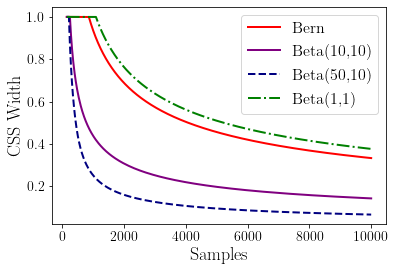

In [12]:
start = 150

plt.plot(range(start, int(iters)), width_bern[start-1:], label='Bern', c='red', lw=2, ls='-')
plt.plot(range(start, int(iters)), width_beta1[start-1:], label='Beta(10,10)', c='purple', lw=2, ls='-')
plt.plot(range(start, int(iters)), width_beta2[start-1:], label='Beta(50,10)', c='navy', lw=2, ls='--')
plt.plot(range(start, int(iters)), width_unif[start-1:], label='Beta(1,1)', c='green', lw=2, ls='-.')
plt.legend(fontsize=16)
# plt.xscale('log')
plt.xlim()
plt.ylabel('CSS Width')
plt.xlabel('Samples')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('emp_bern_bounds_beta.png', dpi=300, bbox_inches='tight')

# Robustness 

In [ ]:
def robust_bernstein(alpha, B, d, iters, eps, gen_vec): 

    adk = A(d, np.sqrt(d))
    
    # Compute lambda 
    lmd = 2 / (3*np.exp(2))
    
    emp_mean_numerator = 1/2
    running_numerator = 9*B*np.sqrt(d) * np.log(1/alpha) / lmd
    running_denominator = 0

    width = []    
    for i in range(1,int(iters)): 

        # Get observations 
        newX = gen_vec(d)

        # Update width 
        running_numerator += 0.036 * np.sqrt(d) * (norm(newX - emp_mean_numerator / i))**2 / B
        running_denominator += 1
        
        width.append(min(running_numerator/running_denominator + eps, 1))
        
        # Update sigma and empirical mean 
        emp_mean_numerator += newX 
        
    return width 


In [ ]:
iters = 10e4
robust_width = robust_bernstein(alpha, B, d, iters, 0.2, gen_unif_vec)

In [ ]:
plt.plot(range(1, int(10e4)), robust_width)